### Acoustic Well Sensing

The data in this notebook comes from the job depicted in this screenshot, where we can see that offset well communication is happening because the offset wells are going up in pressure as the pressure increases in the well that is being completed.  In this case the offset wells are on a different pad ~1/2 mile away. We see communication in the closest wellbore first, and the 2nd closest wellbore 2nd (delayed poroelastic response). 

![example communication](images/communication_example.png)

### Events to detect
 * start of pumping down the perf guns and plugs
 * end of pumping down the perf guns and plugs
 * firing off perf guns
 * start of frac stage
 * detect steep pressurization step in the stage
 * end of frac stage
 * pressurizing to create fractures
 * fractures occurring on active fracking well measuring on active fracking well
 * fractures occuring on active fracking well measuring on offset well
 * detecting signs of well communication
 * detecting communication correlation
 * Detect gear shift (false positive, looks alot like the "pops" when we are fracking, only occurs early in stage

### Goal 
 * produce a fracture report in near real-time
     - log every detected fracture with a timestamp
     - characterize their magnitude, count, detect a seam that cracks rapidly in succession
 * detect early signs of communication using dynamic sensors before we see a static pressure increase in the offset well
     - produce a communication event/alert so that the operator can decide whether they want to continue or not

In [144]:
%load_ext autoreload
%autoreload 2

import os
import sys
base_path = '/home/ubuntu/legend-analytics'
if base_path not in sys.path:
    sys.path.append(base_path)
os.chdir(base_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.io import wavfile

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
plt.rcParams["figure.figsize"] = (20,6)

In [146]:
# Read the wav file (mono)
#sampling_rate, wav = wavfile.read('hy_stage_1_trimmed.wav')

logs = pd.read_csv('data/BRISCOE_CATARINA_WEST_33_frac_logs.csv')

In [147]:
logs.head

<bound method NDFrame.head of      Job_Number|API14#|Activity_Start_Date|Activity_End_Date|Activity_Details
0     ----------|------|-------------------|--------...                      
1     J10118172|42-127-37983|Jan  9 2020  8:38PM|Jan...                      
2     J10118172|42-127-37983|Jan  9 2020  8:55PM|Jan...                      
3     J10118172|42-127-37983|Jan 11 2020  2:41PM|Jan...                      
4     J10118172|42-127-37983|Jan 11 2020  2:58PM|Jan...                      
...                                                 ...                      
2139  J10118173|42-127-37984|Jan 12 2020  7:41PM|Jan...                      
2140  J10118173|42-127-37984|Jan 12 2020  7:54PM|Jan...                      
2141  J10118173|42-127-37984|Jan  7 2020  8:10PM|Jan...                      
2142  J10118173|42-127-37984|Jan  7 2020  8:27PM|Jan...                      
2143                               (2142 rows affected)                      

[2144 rows x 1 columns]>

In [152]:
npy = np.load('data/well-communication/BRISCOE-CATARINA-WEST_33HU_dynamic_c62e0d73-2b63-4fba-8a6a-fd96466b545d_2020-01-07T14:00:00.000Z.npz')
data = npy['arr_0']
print(data.shape, data[0], data[10])
sampling_rate = int(data.shape[0] / 3600)

(152650000,) 25.16341307291661 23.355263630551345


In [130]:
num_bytes = data.nbytes
kbytes = num_bytes / 1024.0
mbytes = kbytes / 1024.0
gbytes = mbytes / 1024.0

print(f"One hour of data => {mbytes:4.3} megabytes ({gbytes:.03} Gb)")

One hour of data => 1.16e+03 megabytes (1.14 Gb)


In [131]:
data = data[:600 * sampling_rate]

In [132]:
freqs, times, spectrums = signal.spectrogram(data, sampling_rate)

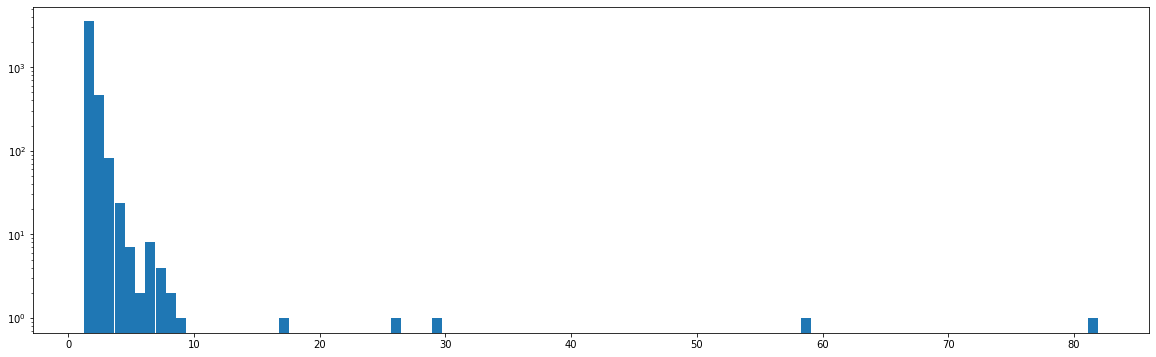

In [133]:
# plt.hist(a, bins='auto')  # arguments are passed to np.histogram
# >>> plt.title("Histogram with 'auto' bins")
# Text(0.5, 1.0, "Histogram with 'auto' bins")
# >>> plt.show()
counts, bin_edges = np.histogram(spectrums, bins=100)
plt.show()

fig, ax = plt.subplots()
ax.bar(bin_edges[2:], counts[1:])
ax.set_yscale('log')
plt.show()

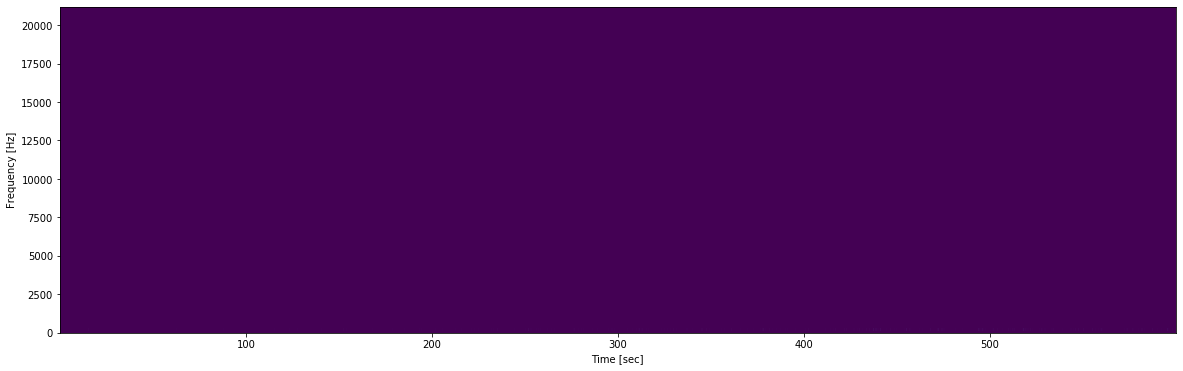

In [134]:
plt.pcolormesh(times, freqs, spectrums)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

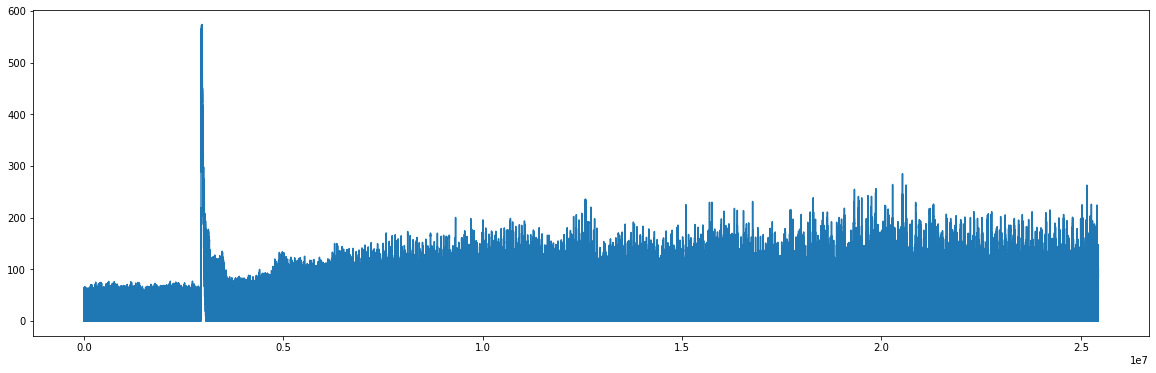

In [135]:
plt.plot(np.abs(data))

In [137]:
spectrums.shape

(129, 113576)

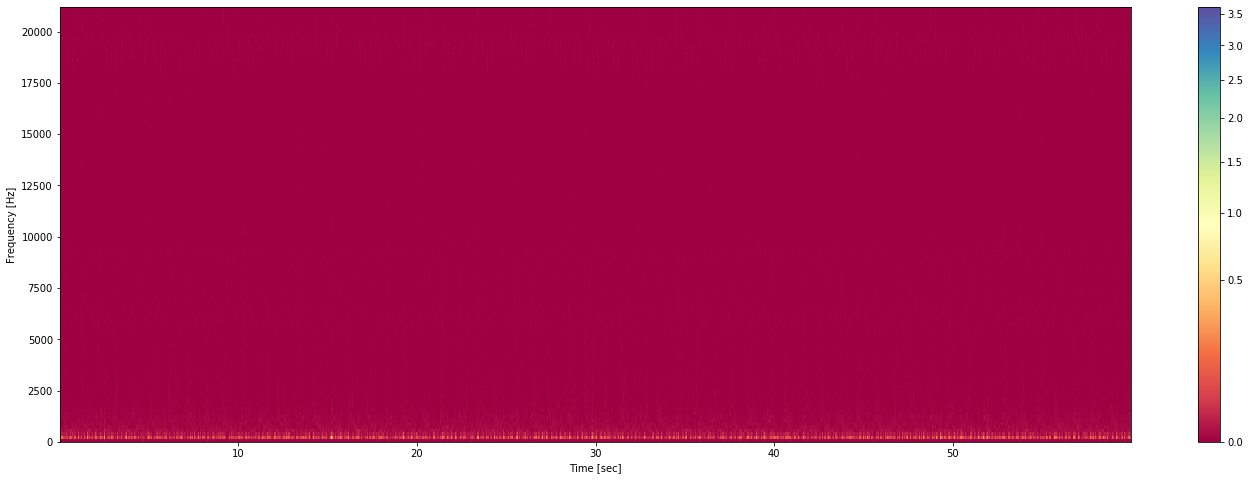

In [138]:
size = len(times)
offset = 0.0
portion = 0.1
a = int(offset * size)
b = int((offset + portion) * size)
n = b - a
min_v = spectrums[:,:n].min()
max_v = spectrums[:,:n].max()

vmin = 0.0
vmax = 2000.0

fig, ax = plt.subplots(figsize=(24,8))
#normalizer = colors.Normalize(vmin=vmin,vmax=vmax)
#normalizer = colors.LogNorm(vmin=vmin, vmax=vmax)
normalizer = colors.PowerNorm(gamma=0.5)

pcm = ax.pcolormesh(times[a:b], freqs, spectrums[:,:n],
                    norm=normalizer,
                    cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

fig.colorbar(pcm)
plt.show()

In [139]:
np.abs(data)

array([25.16341307, 23.50594275, 24.86205483, ..., 85.20904247,
       82.79817655, 83.77759083])